In [1]:
import torch
from audiocraft.models.musicgen import MusicGen
from audiocraft.modules.conditioners import ChromaChordConditioner
from audiocraft.solvers.compression import CompressionSolver
import math
from pathlib import Path

/home/sake/.virtualenvs/MusicGen_Chord-VFGWlmB1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
loaded = torch.load("/home/sake/checkpoint_30.th")

In [3]:
# from sys import getsizeof
# [x for x in loaded['model'].keys()]

In [4]:
# len([x for x in loaded['model'].values()])

In [5]:
# [x.shape for x in loaded['best_state']['model'].values()]

In [49]:
from audiocraft.models.builders import get_lm_model, get_compression_model, get_wrapped_compression_model
from omegaconf import OmegaConf

def _delete_param(cfg, full_name: str):
    parts = full_name.split('.')
    for part in parts[:-1]:
        if part in cfg:
            cfg = cfg[part]
        else:
            return
    OmegaConf.set_struct(cfg, False)
    if parts[-1] in cfg:
        del cfg[parts[-1]]
    OmegaConf.set_struct(cfg, True)

device = 'cuda'

In [50]:
# LM

cfg = OmegaConf.create(loaded['xp.cfg'])
cfg.device = str(device)
if cfg.device == 'cpu':
    cfg.dtype = 'float32'
else:
    cfg.dtype = 'float16'
_delete_param(cfg, 'conditioners.self_wav.chroma_chord.cache_path')
_delete_param(cfg, 'conditioners.self_wav.chroma_stem.cache_path')
_delete_param(cfg, 'conditioners.args.merge_text_conditions_p')
_delete_param(cfg, 'conditioners.args.drop_desc_p')

lm = get_lm_model(loaded['xp.cfg'])
lm.load_state_dict(loaded['fsdp_best_state']['model']) 
lm.eval()
lm.cfg = cfg

In [51]:
compression_model = CompressionSolver.wrapped_model_from_checkpoint(cfg, cfg.compression_model_checkpoint, device=device)

In [52]:
model = MusicGen("sakemin/musicgen-chord", compression_model, lm)

In [53]:
model.set_generation_params(duration=30)
model.lm = model.lm.to('cuda')

In [54]:
target_path = Path("/home/sake/chords_text_gen")

In [55]:
descriptions = ["basic pop song"]
chord_text = 'C G Amin F'
bpm = 110
in_triple = False

for i in range(len(descriptions)):
    if in_triple:
        descriptions[i] = descriptions[i] + ", in triple"
    descriptions[i] = descriptions[i] + f", bpm : {bpm}"

In [56]:
from audiocraft.data.audio import audio_write
import torchaudio
from tqdm import tqdm

In [57]:
path = target_path/descriptions[0]
for i in tqdm(range(1)): 
    # print(descriptions)
    # wav = model.generate(descriptions)  # generates 3 samples.

    wav = model.generate_with_text_chroma(descriptions, chord_text, bpm = bpm, in_triple = in_triple)

    for idx, one_wav in enumerate(wav):
        # Will save under {idx}.wav, with loudness normalization at -14 db LUFS.
        path.mkdir(parents=True, exist_ok=True)
        audio_write(f'{str(path/str(i))}_{i}', one_wav.cpu(), model.sample_rate, strategy="loudness", loudness_compressor=True)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:36<00:00, 36.81s/it]


In [58]:
import pretty_midi as pm

In [59]:
import os
from audiocraft.modules.btc import mir_eval
from audiocraft.modules.btc.utils import logger
from audiocraft.modules.btc.btc_model import *
from audiocraft.modules.btc.utils.mir_eval_modules import audio_file_to_features, idx2chord, idx2voca_chord, get_audio_paths
import argparse
import warnings

warnings.filterwarnings('ignore')
logger.logging_verbosity(1)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

config = HParams.load("/home/sake/musicgen/MusicGen_Chord/audiocraft/modules/btc/run_config.yaml")

config.feature['large_voca'] = True
config.model['num_chords'] = 170
model_file = '/home/sake/musicgen/MusicGen_Chord/audiocraft/modules/btc/test/btc_model_large_voca.pt'
idx_to_chord = idx2voca_chord()

btcmodel = BTC_model(config=config.model).to(device)

# Load model
if os.path.isfile(model_file):
    checkpoint = torch.load(model_file)
    mean = checkpoint['mean']
    std = checkpoint['std']
    btcmodel.load_state_dict(checkpoint['model'])
    logger.info("restore model")

# Audio files with format of wav and mp3
audio_paths = get_audio_paths(path)

# Chord recognition and save lab file
for i, audio_path in enumerate(audio_paths):
    logger.info("======== %d of %d in progress ========" % (i + 1, len(audio_paths)))
    # Load mp3
    feature, feature_per_second, song_length_second = audio_file_to_features(audio_path, config)
    logger.info("audio file loaded and feature computation success : %s" % audio_path)

    # Majmin type chord recognition
    feature = feature.T
    feature = (feature - mean) / std
    time_unit = feature_per_second
    n_timestep = config.model['timestep']

    num_pad = n_timestep - (feature.shape[0] % n_timestep)
    feature = np.pad(feature, ((0, num_pad), (0, 0)), mode="constant", constant_values=0)
    num_instance = feature.shape[0] // n_timestep

    start_time = 0.0
    lines = []
    with torch.no_grad():
        btcmodel.eval()
        feature = torch.tensor(feature, dtype=torch.float32).unsqueeze(0).to(device)
        for t in range(num_instance):
            self_attn_output, _ = btcmodel.self_attn_layers(feature[:, n_timestep * t:n_timestep * (t + 1), :])
            prediction, _ = btcmodel.output_layer(self_attn_output)
            prediction = prediction.squeeze()
            for i in range(n_timestep):
                if t == 0 and i == 0:
                    prev_chord = prediction[i].item()
                    continue
                if prediction[i].item() != prev_chord:
                    lines.append(
                        '%.3f %.3f %s\n' % (start_time, time_unit * (n_timestep * t + i), idx_to_chord[prev_chord]))
                    start_time = time_unit * (n_timestep * t + i)
                    prev_chord = prediction[i].item()
                if t == num_instance - 1 and i + num_pad == n_timestep:
                    if start_time != time_unit * (n_timestep * t + i):
                        lines.append('%.3f %.3f %s\n' % (start_time, time_unit * (n_timestep * t + i), idx_to_chord[prev_chord]))
                    break

    # lab file write
    if not os.path.exists(path):
        os.makedirs(path)
    save_path = os.path.join(path, os.path.split(audio_path)[-1].replace('.mp3', '').replace('.wav', '') + '.lab')
    with open(save_path, 'w') as f:
        for line in lines:
            f.write(line)

    logger.info("label file saved : %s" % save_path)

    # lab file to midi file
    

    starts, ends, pitchs = list(), list(), list()

    intervals, chords = mir_eval.io.load_labeled_intervals(save_path)
    for p in range(12):
        for i, (interval, chord) in enumerate(zip(intervals, chords)):
            root_num, relative_bitmap, _ = mir_eval.chord.encode(chord)
            tmp_label = mir_eval.chord.rotate_bitmap_to_root(relative_bitmap, root_num)[p]
            if i == 0:
                start_time = interval[0]
                label = tmp_label
                continue
            if tmp_label != label:
                if label == 1.0:
                    starts.append(start_time), ends.append(interval[0]), pitchs.append(p + 48)
                start_time = interval[0]
                label = tmp_label
            if i == (len(intervals) - 1): 
                if label == 1.0:
                    starts.append(start_time), ends.append(interval[1]), pitchs.append(p + 48)

    midi = pm.PrettyMIDI()
    instrument = pm.Instrument(program=0)

    for start, end, pitch in zip(starts, ends, pitchs):
        pm_note = pm.Note(velocity=120, pitch=pitch, start=start, end=end)
        instrument.notes.append(pm_note)

    midi.instruments.append(instrument)
    midi.write(save_path.replace('.lab', '.midi'))    



I MusicGen_Chord 09-19 09:01:14.100 333405880.py:29] restore model
I MusicGen_Chord 09-19 09:01:14.101 333405880.py:36] ======== 1 of 1 in progress ========
I MusicGen_Chord 09-19 09:01:14.239 333405880.py:39] audio file loaded and feature computation success : /home/sake/chords_text_gen/basic pop song, bpm : 110/0_0.wav


I MusicGen_Chord 09-19 09:01:14.298 333405880.py:82] label file saved : /home/sake/chords_text_gen/basic pop song, bpm : 110/0_0.lab


In [60]:
chordreader = Chords()

In [61]:
crds = chordreader.load_chords(save_path)

In [62]:
crds

array([( 0.   ,  2.13 , (4, 0, [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0], False)),
       ( 2.13 ,  4.259, (2, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True)),
       ( 4.259,  6.574, (0, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True)),
       ( 6.574,  8.889, (7, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True)),
       ( 8.889, 10.833, (9, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True)),
       (10.833, 13.056, (2, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True)),
       (13.056, 15.185, (0, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True)),
       (15.185, 17.5  , (7, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True)),
       (17.5  , 19.167, (4, 0, [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0], False)),
       (19.167, 19.63 , (4, 0, [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0], False)),
       (19.63 , 21.852, (2, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True)),
       (21.852, 23.796, (0, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  True)),
       (23.796, 26.389, (7, 0, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,

In [63]:
timebin = 30/235
chroma = torch.zeros([235,12])

In [64]:
count = 0
for crd in crds:
    if count >= 235: 
        break
    if crd[2][0] == -1:
        multihot = torch.Tensor(crd[2][2])
    else:
        multihot = torch.concat([torch.Tensor(crd[2][2])[-crd[2][0]:],torch.Tensor(crd[2][2])[:-crd[2][0]]])
    start_bin = round(crd[0]/timebin)
    end_bin = round(crd[1]/timebin)
    for j in range(start_bin,end_bin):
        if count >= 235: 
            break
        chroma[j]=multihot
        count += 1

In [65]:
import matplotlib.pyplot as plt

In [66]:
chroma

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 1.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 1., 0., 0.]])

In [70]:
import IPython.display as ipd
ipd.Audio(save_path.replace('.lab', '.wav'))

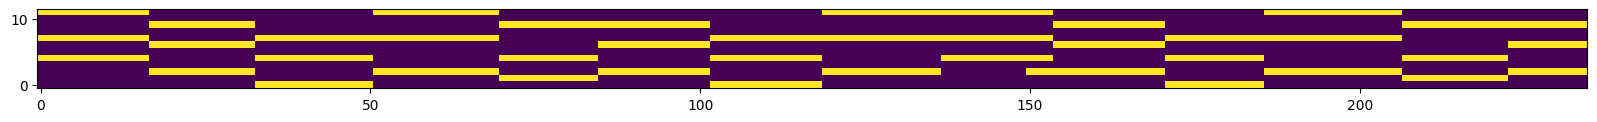

In [69]:
plt.figure(figsize = (20,2))
plt.imshow(chroma.T, origin='lower', interpolation='nearest')

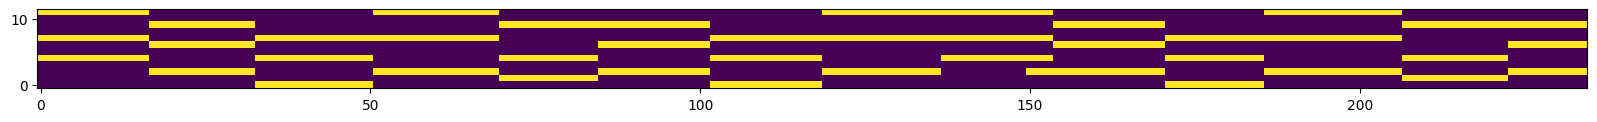

In [68]:
plt.figure(figsize = (20,2))
plt.imshow(chroma.T, origin='lower', interpolation='nearest')
plt.savefig(save_path.replace('.lab', '.png'))

In [72]:
chord_text

'C G Amin F'

In [71]:
chords

['E:min',
 'D',
 'C',
 'G',
 'A',
 'D',
 'C',
 'G',
 'E:min',
 'E:min7',
 'D',
 'C',
 'G',
 'A',
 'D']

In [33]:
loaded['xp.cfg']

{'device': 'cuda', 'dtype': 'float32', 'autocast': False, 'autocast_dtype': 'float16', 'seed': 2036, 'show': False, 'continue_from': None, 'execute_only': None, 'execute_inplace': False, 'benchmark_no_load': False, 'efficient_attention_backend': 'torch', 'num_threads': 1, 'mp_start_method': 'forkserver', 'label': None, 'logging': {'level': 'INFO', 'log_updates': 100, 'log_tensorboard': True, 'log_wandb': True}, 'tensorboard': {'with_media_logging': True, 'name': None, 'sub_dir': None}, 'wandb': {'with_media_logging': True, 'project': 'audiocraft_chord', 'name': None, 'group': None, 'entity': 'sakemin'}, 'slurm': {'gpus': 8, 'mem_per_gpu': 40, 'time': 3600, 'constraint': None, 'partition': None, 'comment': None, 'setup': [], 'exclude': ''}, 'dora': {'dir': '/checkpoint/${oc.env:USER}/experiments/audiocraft/outputs', 'exclude': ['device', 'wandb.*', 'tensorboard.*', 'logging.*', 'dataset.num_workers', 'eval.num_workers', 'special.*', 'metrics.visqol.bin', 'metrics.fad.bin', 'execute_only

In [ ]:
loaded['compression_model']

In [37]:
model.lm.load_state_dict(loaded['best_state'])
model.lm.to('cuda')

RuntimeError: Error(s) in loading state_dict for LMModel:
	Missing key(s) in state_dict: "condition_provider.conditioners.self_wav.output_proj.weight", "condition_provider.conditioners.self_wav.output_proj.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.embedding_proj.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.attn_block.multi_head_attention.query_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.attn_block.multi_head_attention.key_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.attn_block.multi_head_attention.value_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.attn_block.multi_head_attention.output_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.attn_block.positionwise_convolution.layers.0.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.attn_block.positionwise_convolution.layers.0.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.attn_block.positionwise_convolution.layers.1.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.attn_block.positionwise_convolution.layers.1.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.attn_block.layer_norm_mha.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.attn_block.layer_norm_mha.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.attn_block.layer_norm_ffn.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.attn_block.layer_norm_ffn.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.backward_attn_block.multi_head_attention.query_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.backward_attn_block.multi_head_attention.key_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.backward_attn_block.multi_head_attention.value_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.backward_attn_block.multi_head_attention.output_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.backward_attn_block.positionwise_convolution.layers.0.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.backward_attn_block.positionwise_convolution.layers.0.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.backward_attn_block.positionwise_convolution.layers.1.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.backward_attn_block.positionwise_convolution.layers.1.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.backward_attn_block.layer_norm_mha.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.backward_attn_block.layer_norm_mha.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.backward_attn_block.layer_norm_ffn.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.backward_attn_block.layer_norm_ffn.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.0.linear.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.attn_block.multi_head_attention.query_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.attn_block.multi_head_attention.key_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.attn_block.multi_head_attention.value_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.attn_block.multi_head_attention.output_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.attn_block.positionwise_convolution.layers.0.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.attn_block.positionwise_convolution.layers.0.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.attn_block.positionwise_convolution.layers.1.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.attn_block.positionwise_convolution.layers.1.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.attn_block.layer_norm_mha.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.attn_block.layer_norm_mha.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.attn_block.layer_norm_ffn.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.attn_block.layer_norm_ffn.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.backward_attn_block.multi_head_attention.query_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.backward_attn_block.multi_head_attention.key_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.backward_attn_block.multi_head_attention.value_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.backward_attn_block.multi_head_attention.output_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.backward_attn_block.positionwise_convolution.layers.0.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.backward_attn_block.positionwise_convolution.layers.0.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.backward_attn_block.positionwise_convolution.layers.1.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.backward_attn_block.positionwise_convolution.layers.1.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.backward_attn_block.layer_norm_mha.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.backward_attn_block.layer_norm_mha.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.backward_attn_block.layer_norm_ffn.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.backward_attn_block.layer_norm_ffn.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.1.linear.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.attn_block.multi_head_attention.query_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.attn_block.multi_head_attention.key_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.attn_block.multi_head_attention.value_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.attn_block.multi_head_attention.output_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.attn_block.positionwise_convolution.layers.0.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.attn_block.positionwise_convolution.layers.0.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.attn_block.positionwise_convolution.layers.1.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.attn_block.positionwise_convolution.layers.1.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.attn_block.layer_norm_mha.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.attn_block.layer_norm_mha.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.attn_block.layer_norm_ffn.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.attn_block.layer_norm_ffn.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.backward_attn_block.multi_head_attention.query_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.backward_attn_block.multi_head_attention.key_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.backward_attn_block.multi_head_attention.value_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.backward_attn_block.multi_head_attention.output_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.backward_attn_block.positionwise_convolution.layers.0.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.backward_attn_block.positionwise_convolution.layers.0.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.backward_attn_block.positionwise_convolution.layers.1.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.backward_attn_block.positionwise_convolution.layers.1.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.backward_attn_block.layer_norm_mha.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.backward_attn_block.layer_norm_mha.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.backward_attn_block.layer_norm_ffn.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.backward_attn_block.layer_norm_ffn.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.2.linear.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.attn_block.multi_head_attention.query_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.attn_block.multi_head_attention.key_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.attn_block.multi_head_attention.value_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.attn_block.multi_head_attention.output_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.attn_block.positionwise_convolution.layers.0.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.attn_block.positionwise_convolution.layers.0.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.attn_block.positionwise_convolution.layers.1.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.attn_block.positionwise_convolution.layers.1.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.attn_block.layer_norm_mha.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.attn_block.layer_norm_mha.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.attn_block.layer_norm_ffn.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.attn_block.layer_norm_ffn.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.backward_attn_block.multi_head_attention.query_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.backward_attn_block.multi_head_attention.key_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.backward_attn_block.multi_head_attention.value_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.backward_attn_block.multi_head_attention.output_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.backward_attn_block.positionwise_convolution.layers.0.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.backward_attn_block.positionwise_convolution.layers.0.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.backward_attn_block.positionwise_convolution.layers.1.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.backward_attn_block.positionwise_convolution.layers.1.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.backward_attn_block.layer_norm_mha.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.backward_attn_block.layer_norm_mha.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.backward_attn_block.layer_norm_ffn.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.backward_attn_block.layer_norm_ffn.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.3.linear.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.attn_block.multi_head_attention.query_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.attn_block.multi_head_attention.key_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.attn_block.multi_head_attention.value_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.attn_block.multi_head_attention.output_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.attn_block.positionwise_convolution.layers.0.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.attn_block.positionwise_convolution.layers.0.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.attn_block.positionwise_convolution.layers.1.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.attn_block.positionwise_convolution.layers.1.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.attn_block.layer_norm_mha.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.attn_block.layer_norm_mha.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.attn_block.layer_norm_ffn.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.attn_block.layer_norm_ffn.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.backward_attn_block.multi_head_attention.query_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.backward_attn_block.multi_head_attention.key_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.backward_attn_block.multi_head_attention.value_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.backward_attn_block.multi_head_attention.output_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.backward_attn_block.positionwise_convolution.layers.0.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.backward_attn_block.positionwise_convolution.layers.0.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.backward_attn_block.positionwise_convolution.layers.1.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.backward_attn_block.positionwise_convolution.layers.1.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.backward_attn_block.layer_norm_mha.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.backward_attn_block.layer_norm_mha.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.backward_attn_block.layer_norm_ffn.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.backward_attn_block.layer_norm_ffn.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.4.linear.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.attn_block.multi_head_attention.query_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.attn_block.multi_head_attention.key_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.attn_block.multi_head_attention.value_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.attn_block.multi_head_attention.output_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.attn_block.positionwise_convolution.layers.0.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.attn_block.positionwise_convolution.layers.0.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.attn_block.positionwise_convolution.layers.1.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.attn_block.positionwise_convolution.layers.1.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.attn_block.layer_norm_mha.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.attn_block.layer_norm_mha.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.attn_block.layer_norm_ffn.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.attn_block.layer_norm_ffn.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.backward_attn_block.multi_head_attention.query_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.backward_attn_block.multi_head_attention.key_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.backward_attn_block.multi_head_attention.value_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.backward_attn_block.multi_head_attention.output_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.backward_attn_block.positionwise_convolution.layers.0.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.backward_attn_block.positionwise_convolution.layers.0.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.backward_attn_block.positionwise_convolution.layers.1.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.backward_attn_block.positionwise_convolution.layers.1.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.backward_attn_block.layer_norm_mha.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.backward_attn_block.layer_norm_mha.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.backward_attn_block.layer_norm_ffn.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.backward_attn_block.layer_norm_ffn.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.5.linear.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.attn_block.multi_head_attention.query_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.attn_block.multi_head_attention.key_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.attn_block.multi_head_attention.value_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.attn_block.multi_head_attention.output_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.attn_block.positionwise_convolution.layers.0.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.attn_block.positionwise_convolution.layers.0.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.attn_block.positionwise_convolution.layers.1.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.attn_block.positionwise_convolution.layers.1.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.attn_block.layer_norm_mha.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.attn_block.layer_norm_mha.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.attn_block.layer_norm_ffn.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.attn_block.layer_norm_ffn.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.backward_attn_block.multi_head_attention.query_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.backward_attn_block.multi_head_attention.key_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.backward_attn_block.multi_head_attention.value_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.backward_attn_block.multi_head_attention.output_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.backward_attn_block.positionwise_convolution.layers.0.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.backward_attn_block.positionwise_convolution.layers.0.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.backward_attn_block.positionwise_convolution.layers.1.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.backward_attn_block.positionwise_convolution.layers.1.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.backward_attn_block.layer_norm_mha.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.backward_attn_block.layer_norm_mha.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.backward_attn_block.layer_norm_ffn.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.backward_attn_block.layer_norm_ffn.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.6.linear.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.attn_block.multi_head_attention.query_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.attn_block.multi_head_attention.key_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.attn_block.multi_head_attention.value_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.attn_block.multi_head_attention.output_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.attn_block.positionwise_convolution.layers.0.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.attn_block.positionwise_convolution.layers.0.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.attn_block.positionwise_convolution.layers.1.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.attn_block.positionwise_convolution.layers.1.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.attn_block.layer_norm_mha.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.attn_block.layer_norm_mha.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.attn_block.layer_norm_ffn.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.attn_block.layer_norm_ffn.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.backward_attn_block.multi_head_attention.query_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.backward_attn_block.multi_head_attention.key_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.backward_attn_block.multi_head_attention.value_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.backward_attn_block.multi_head_attention.output_linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.backward_attn_block.positionwise_convolution.layers.0.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.backward_attn_block.positionwise_convolution.layers.0.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.backward_attn_block.positionwise_convolution.layers.1.conv.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.backward_attn_block.positionwise_convolution.layers.1.conv.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.backward_attn_block.layer_norm_mha.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.backward_attn_block.layer_norm_mha.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.backward_attn_block.layer_norm_ffn.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.backward_attn_block.layer_norm_ffn.beta", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.linear.weight", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.self_attn_layers.7.linear.bias", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.layer_norm.gamma", "condition_provider.conditioners.self_wav.chroma.model.self_attn_layers.layer_norm.beta", "condition_provider.conditioners.self_wav.chroma.model.output_layer.output_projection.weight", "condition_provider.conditioners.self_wav.chroma.model.output_layer.output_projection.bias", "condition_provider.conditioners.self_wav.chroma.model.output_layer.lstm.weight_ih_l0", "condition_provider.conditioners.self_wav.chroma.model.output_layer.lstm.weight_hh_l0", "condition_provider.conditioners.self_wav.chroma.model.output_layer.lstm.bias_ih_l0", "condition_provider.conditioners.self_wav.chroma.model.output_layer.lstm.bias_hh_l0", "condition_provider.conditioners.self_wav.chroma.model.output_layer.lstm.weight_ih_l0_reverse", "condition_provider.conditioners.self_wav.chroma.model.output_layer.lstm.weight_hh_l0_reverse", "condition_provider.conditioners.self_wav.chroma.model.output_layer.lstm.bias_ih_l0_reverse", "condition_provider.conditioners.self_wav.chroma.model.output_layer.lstm.bias_hh_l0_reverse", "condition_provider.conditioners.description.output_proj.weight", "condition_provider.conditioners.description.output_proj.bias", "emb.0.weight", "emb.1.weight", "emb.2.weight", "emb.3.weight", "transformer.layers.0.self_attn.in_proj_weight", "transformer.layers.0.self_attn.out_proj.weight", "transformer.layers.0.linear1.weight", "transformer.layers.0.linear2.weight", "transformer.layers.0.norm1.weight", "transformer.layers.0.norm1.bias", "transformer.layers.0.norm2.weight", "transformer.layers.0.norm2.bias", "transformer.layers.1.self_attn.in_proj_weight", "transformer.layers.1.self_attn.out_proj.weight", "transformer.layers.1.linear1.weight", "transformer.layers.1.linear2.weight", "transformer.layers.1.norm1.weight", "transformer.layers.1.norm1.bias", "transformer.layers.1.norm2.weight", "transformer.layers.1.norm2.bias", "transformer.layers.2.self_attn.in_proj_weight", "transformer.layers.2.self_attn.out_proj.weight", "transformer.layers.2.linear1.weight", "transformer.layers.2.linear2.weight", "transformer.layers.2.norm1.weight", "transformer.layers.2.norm1.bias", "transformer.layers.2.norm2.weight", "transformer.layers.2.norm2.bias", "transformer.layers.3.self_attn.in_proj_weight", "transformer.layers.3.self_attn.out_proj.weight", "transformer.layers.3.linear1.weight", "transformer.layers.3.linear2.weight", "transformer.layers.3.norm1.weight", "transformer.layers.3.norm1.bias", "transformer.layers.3.norm2.weight", "transformer.layers.3.norm2.bias", "transformer.layers.4.self_attn.in_proj_weight", "transformer.layers.4.self_attn.out_proj.weight", "transformer.layers.4.linear1.weight", "transformer.layers.4.linear2.weight", "transformer.layers.4.norm1.weight", "transformer.layers.4.norm1.bias", "transformer.layers.4.norm2.weight", "transformer.layers.4.norm2.bias", "transformer.layers.5.self_attn.in_proj_weight", "transformer.layers.5.self_attn.out_proj.weight", "transformer.layers.5.linear1.weight", "transformer.layers.5.linear2.weight", "transformer.layers.5.norm1.weight", "transformer.layers.5.norm1.bias", "transformer.layers.5.norm2.weight", "transformer.layers.5.norm2.bias", "transformer.layers.6.self_attn.in_proj_weight", "transformer.layers.6.self_attn.out_proj.weight", "transformer.layers.6.linear1.weight", "transformer.layers.6.linear2.weight", "transformer.layers.6.norm1.weight", "transformer.layers.6.norm1.bias", "transformer.layers.6.norm2.weight", "transformer.layers.6.norm2.bias", "transformer.layers.7.self_attn.in_proj_weight", "transformer.layers.7.self_attn.out_proj.weight", "transformer.layers.7.linear1.weight", "transformer.layers.7.linear2.weight", "transformer.layers.7.norm1.weight", "transformer.layers.7.norm1.bias", "transformer.layers.7.norm2.weight", "transformer.layers.7.norm2.bias", "transformer.layers.8.self_attn.in_proj_weight", "transformer.layers.8.self_attn.out_proj.weight", "transformer.layers.8.linear1.weight", "transformer.layers.8.linear2.weight", "transformer.layers.8.norm1.weight", "transformer.layers.8.norm1.bias", "transformer.layers.8.norm2.weight", "transformer.layers.8.norm2.bias", "transformer.layers.9.self_attn.in_proj_weight", "transformer.layers.9.self_attn.out_proj.weight", "transformer.layers.9.linear1.weight", "transformer.layers.9.linear2.weight", "transformer.layers.9.norm1.weight", "transformer.layers.9.norm1.bias", "transformer.layers.9.norm2.weight", "transformer.layers.9.norm2.bias", "transformer.layers.10.self_attn.in_proj_weight", "transformer.layers.10.self_attn.out_proj.weight", "transformer.layers.10.linear1.weight", "transformer.layers.10.linear2.weight", "transformer.layers.10.norm1.weight", "transformer.layers.10.norm1.bias", "transformer.layers.10.norm2.weight", "transformer.layers.10.norm2.bias", "transformer.layers.11.self_attn.in_proj_weight", "transformer.layers.11.self_attn.out_proj.weight", "transformer.layers.11.linear1.weight", "transformer.layers.11.linear2.weight", "transformer.layers.11.norm1.weight", "transformer.layers.11.norm1.bias", "transformer.layers.11.norm2.weight", "transformer.layers.11.norm2.bias", "transformer.layers.12.self_attn.in_proj_weight", "transformer.layers.12.self_attn.out_proj.weight", "transformer.layers.12.linear1.weight", "transformer.layers.12.linear2.weight", "transformer.layers.12.norm1.weight", "transformer.layers.12.norm1.bias", "transformer.layers.12.norm2.weight", "transformer.layers.12.norm2.bias", "transformer.layers.13.self_attn.in_proj_weight", "transformer.layers.13.self_attn.out_proj.weight", "transformer.layers.13.linear1.weight", "transformer.layers.13.linear2.weight", "transformer.layers.13.norm1.weight", "transformer.layers.13.norm1.bias", "transformer.layers.13.norm2.weight", "transformer.layers.13.norm2.bias", "transformer.layers.14.self_attn.in_proj_weight", "transformer.layers.14.self_attn.out_proj.weight", "transformer.layers.14.linear1.weight", "transformer.layers.14.linear2.weight", "transformer.layers.14.norm1.weight", "transformer.layers.14.norm1.bias", "transformer.layers.14.norm2.weight", "transformer.layers.14.norm2.bias", "transformer.layers.15.self_attn.in_proj_weight", "transformer.layers.15.self_attn.out_proj.weight", "transformer.layers.15.linear1.weight", "transformer.layers.15.linear2.weight", "transformer.layers.15.norm1.weight", "transformer.layers.15.norm1.bias", "transformer.layers.15.norm2.weight", "transformer.layers.15.norm2.bias", "transformer.layers.16.self_attn.in_proj_weight", "transformer.layers.16.self_attn.out_proj.weight", "transformer.layers.16.linear1.weight", "transformer.layers.16.linear2.weight", "transformer.layers.16.norm1.weight", "transformer.layers.16.norm1.bias", "transformer.layers.16.norm2.weight", "transformer.layers.16.norm2.bias", "transformer.layers.17.self_attn.in_proj_weight", "transformer.layers.17.self_attn.out_proj.weight", "transformer.layers.17.linear1.weight", "transformer.layers.17.linear2.weight", "transformer.layers.17.norm1.weight", "transformer.layers.17.norm1.bias", "transformer.layers.17.norm2.weight", "transformer.layers.17.norm2.bias", "transformer.layers.18.self_attn.in_proj_weight", "transformer.layers.18.self_attn.out_proj.weight", "transformer.layers.18.linear1.weight", "transformer.layers.18.linear2.weight", "transformer.layers.18.norm1.weight", "transformer.layers.18.norm1.bias", "transformer.layers.18.norm2.weight", "transformer.layers.18.norm2.bias", "transformer.layers.19.self_attn.in_proj_weight", "transformer.layers.19.self_attn.out_proj.weight", "transformer.layers.19.linear1.weight", "transformer.layers.19.linear2.weight", "transformer.layers.19.norm1.weight", "transformer.layers.19.norm1.bias", "transformer.layers.19.norm2.weight", "transformer.layers.19.norm2.bias", "transformer.layers.20.self_attn.in_proj_weight", "transformer.layers.20.self_attn.out_proj.weight", "transformer.layers.20.linear1.weight", "transformer.layers.20.linear2.weight", "transformer.layers.20.norm1.weight", "transformer.layers.20.norm1.bias", "transformer.layers.20.norm2.weight", "transformer.layers.20.norm2.bias", "transformer.layers.21.self_attn.in_proj_weight", "transformer.layers.21.self_attn.out_proj.weight", "transformer.layers.21.linear1.weight", "transformer.layers.21.linear2.weight", "transformer.layers.21.norm1.weight", "transformer.layers.21.norm1.bias", "transformer.layers.21.norm2.weight", "transformer.layers.21.norm2.bias", "transformer.layers.22.self_attn.in_proj_weight", "transformer.layers.22.self_attn.out_proj.weight", "transformer.layers.22.linear1.weight", "transformer.layers.22.linear2.weight", "transformer.layers.22.norm1.weight", "transformer.layers.22.norm1.bias", "transformer.layers.22.norm2.weight", "transformer.layers.22.norm2.bias", "transformer.layers.23.self_attn.in_proj_weight", "transformer.layers.23.self_attn.out_proj.weight", "transformer.layers.23.linear1.weight", "transformer.layers.23.linear2.weight", "transformer.layers.23.norm1.weight", "transformer.layers.23.norm1.bias", "transformer.layers.23.norm2.weight", "transformer.layers.23.norm2.bias", "transformer.layers.24.self_attn.in_proj_weight", "transformer.layers.24.self_attn.out_proj.weight", "transformer.layers.24.linear1.weight", "transformer.layers.24.linear2.weight", "transformer.layers.24.norm1.weight", "transformer.layers.24.norm1.bias", "transformer.layers.24.norm2.weight", "transformer.layers.24.norm2.bias", "transformer.layers.25.self_attn.in_proj_weight", "transformer.layers.25.self_attn.out_proj.weight", "transformer.layers.25.linear1.weight", "transformer.layers.25.linear2.weight", "transformer.layers.25.norm1.weight", "transformer.layers.25.norm1.bias", "transformer.layers.25.norm2.weight", "transformer.layers.25.norm2.bias", "transformer.layers.26.self_attn.in_proj_weight", "transformer.layers.26.self_attn.out_proj.weight", "transformer.layers.26.linear1.weight", "transformer.layers.26.linear2.weight", "transformer.layers.26.norm1.weight", "transformer.layers.26.norm1.bias", "transformer.layers.26.norm2.weight", "transformer.layers.26.norm2.bias", "transformer.layers.27.self_attn.in_proj_weight", "transformer.layers.27.self_attn.out_proj.weight", "transformer.layers.27.linear1.weight", "transformer.layers.27.linear2.weight", "transformer.layers.27.norm1.weight", "transformer.layers.27.norm1.bias", "transformer.layers.27.norm2.weight", "transformer.layers.27.norm2.bias", "transformer.layers.28.self_attn.in_proj_weight", "transformer.layers.28.self_attn.out_proj.weight", "transformer.layers.28.linear1.weight", "transformer.layers.28.linear2.weight", "transformer.layers.28.norm1.weight", "transformer.layers.28.norm1.bias", "transformer.layers.28.norm2.weight", "transformer.layers.28.norm2.bias", "transformer.layers.29.self_attn.in_proj_weight", "transformer.layers.29.self_attn.out_proj.weight", "transformer.layers.29.linear1.weight", "transformer.layers.29.linear2.weight", "transformer.layers.29.norm1.weight", "transformer.layers.29.norm1.bias", "transformer.layers.29.norm2.weight", "transformer.layers.29.norm2.bias", "transformer.layers.30.self_attn.in_proj_weight", "transformer.layers.30.self_attn.out_proj.weight", "transformer.layers.30.linear1.weight", "transformer.layers.30.linear2.weight", "transformer.layers.30.norm1.weight", "transformer.layers.30.norm1.bias", "transformer.layers.30.norm2.weight", "transformer.layers.30.norm2.bias", "transformer.layers.31.self_attn.in_proj_weight", "transformer.layers.31.self_attn.out_proj.weight", "transformer.layers.31.linear1.weight", "transformer.layers.31.linear2.weight", "transformer.layers.31.norm1.weight", "transformer.layers.31.norm1.bias", "transformer.layers.31.norm2.weight", "transformer.layers.31.norm2.bias", "transformer.layers.32.self_attn.in_proj_weight", "transformer.layers.32.self_attn.out_proj.weight", "transformer.layers.32.linear1.weight", "transformer.layers.32.linear2.weight", "transformer.layers.32.norm1.weight", "transformer.layers.32.norm1.bias", "transformer.layers.32.norm2.weight", "transformer.layers.32.norm2.bias", "transformer.layers.33.self_attn.in_proj_weight", "transformer.layers.33.self_attn.out_proj.weight", "transformer.layers.33.linear1.weight", "transformer.layers.33.linear2.weight", "transformer.layers.33.norm1.weight", "transformer.layers.33.norm1.bias", "transformer.layers.33.norm2.weight", "transformer.layers.33.norm2.bias", "transformer.layers.34.self_attn.in_proj_weight", "transformer.layers.34.self_attn.out_proj.weight", "transformer.layers.34.linear1.weight", "transformer.layers.34.linear2.weight", "transformer.layers.34.norm1.weight", "transformer.layers.34.norm1.bias", "transformer.layers.34.norm2.weight", "transformer.layers.34.norm2.bias", "transformer.layers.35.self_attn.in_proj_weight", "transformer.layers.35.self_attn.out_proj.weight", "transformer.layers.35.linear1.weight", "transformer.layers.35.linear2.weight", "transformer.layers.35.norm1.weight", "transformer.layers.35.norm1.bias", "transformer.layers.35.norm2.weight", "transformer.layers.35.norm2.bias", "transformer.layers.36.self_attn.in_proj_weight", "transformer.layers.36.self_attn.out_proj.weight", "transformer.layers.36.linear1.weight", "transformer.layers.36.linear2.weight", "transformer.layers.36.norm1.weight", "transformer.layers.36.norm1.bias", "transformer.layers.36.norm2.weight", "transformer.layers.36.norm2.bias", "transformer.layers.37.self_attn.in_proj_weight", "transformer.layers.37.self_attn.out_proj.weight", "transformer.layers.37.linear1.weight", "transformer.layers.37.linear2.weight", "transformer.layers.37.norm1.weight", "transformer.layers.37.norm1.bias", "transformer.layers.37.norm2.weight", "transformer.layers.37.norm2.bias", "transformer.layers.38.self_attn.in_proj_weight", "transformer.layers.38.self_attn.out_proj.weight", "transformer.layers.38.linear1.weight", "transformer.layers.38.linear2.weight", "transformer.layers.38.norm1.weight", "transformer.layers.38.norm1.bias", "transformer.layers.38.norm2.weight", "transformer.layers.38.norm2.bias", "transformer.layers.39.self_attn.in_proj_weight", "transformer.layers.39.self_attn.out_proj.weight", "transformer.layers.39.linear1.weight", "transformer.layers.39.linear2.weight", "transformer.layers.39.norm1.weight", "transformer.layers.39.norm1.bias", "transformer.layers.39.norm2.weight", "transformer.layers.39.norm2.bias", "transformer.layers.40.self_attn.in_proj_weight", "transformer.layers.40.self_attn.out_proj.weight", "transformer.layers.40.linear1.weight", "transformer.layers.40.linear2.weight", "transformer.layers.40.norm1.weight", "transformer.layers.40.norm1.bias", "transformer.layers.40.norm2.weight", "transformer.layers.40.norm2.bias", "transformer.layers.41.self_attn.in_proj_weight", "transformer.layers.41.self_attn.out_proj.weight", "transformer.layers.41.linear1.weight", "transformer.layers.41.linear2.weight", "transformer.layers.41.norm1.weight", "transformer.layers.41.norm1.bias", "transformer.layers.41.norm2.weight", "transformer.layers.41.norm2.bias", "transformer.layers.42.self_attn.in_proj_weight", "transformer.layers.42.self_attn.out_proj.weight", "transformer.layers.42.linear1.weight", "transformer.layers.42.linear2.weight", "transformer.layers.42.norm1.weight", "transformer.layers.42.norm1.bias", "transformer.layers.42.norm2.weight", "transformer.layers.42.norm2.bias", "transformer.layers.43.self_attn.in_proj_weight", "transformer.layers.43.self_attn.out_proj.weight", "transformer.layers.43.linear1.weight", "transformer.layers.43.linear2.weight", "transformer.layers.43.norm1.weight", "transformer.layers.43.norm1.bias", "transformer.layers.43.norm2.weight", "transformer.layers.43.norm2.bias", "transformer.layers.44.self_attn.in_proj_weight", "transformer.layers.44.self_attn.out_proj.weight", "transformer.layers.44.linear1.weight", "transformer.layers.44.linear2.weight", "transformer.layers.44.norm1.weight", "transformer.layers.44.norm1.bias", "transformer.layers.44.norm2.weight", "transformer.layers.44.norm2.bias", "transformer.layers.45.self_attn.in_proj_weight", "transformer.layers.45.self_attn.out_proj.weight", "transformer.layers.45.linear1.weight", "transformer.layers.45.linear2.weight", "transformer.layers.45.norm1.weight", "transformer.layers.45.norm1.bias", "transformer.layers.45.norm2.weight", "transformer.layers.45.norm2.bias", "transformer.layers.46.self_attn.in_proj_weight", "transformer.layers.46.self_attn.out_proj.weight", "transformer.layers.46.linear1.weight", "transformer.layers.46.linear2.weight", "transformer.layers.46.norm1.weight", "transformer.layers.46.norm1.bias", "transformer.layers.46.norm2.weight", "transformer.layers.46.norm2.bias", "transformer.layers.47.self_attn.in_proj_weight", "transformer.layers.47.self_attn.out_proj.weight", "transformer.layers.47.linear1.weight", "transformer.layers.47.linear2.weight", "transformer.layers.47.norm1.weight", "transformer.layers.47.norm1.bias", "transformer.layers.47.norm2.weight", "transformer.layers.47.norm2.bias", "out_norm.weight", "out_norm.bias", "linears.0.weight", "linears.1.weight", "linears.2.weight", "linears.3.weight". 
	Unexpected key(s) in state_dict: "model". 

In [9]:
target_path = Path("/home/sake/chords_text_gen")

In [17]:
loaded.keys()

dict_keys(['history', 'xp.cfg', 'xp.sig', 'best_state', 'fsdp_best_state', 'compression_model', 'model', 'optimizer', 'lr_scheduler', 'ema'])

In [ ]:
loaded['fsdp_best_state']

In [ ]:
loaded['model']

In [16]:
loaded['model']['condition_provider.conditioners.self_wav.output_proj.weight'].shape

torch.Size([18432])